In [26]:
import spacy
import pandas as pd

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Keywords for identifying gender-based stereotypes
male_keywords = ["he", "him", "his", "son", "father", "businessman", "owner", "leader", "hero"]
female_keywords = ["she", "her", "daughter", "wife", "mother", "beautiful", "emotional", "dependent"]

# Function to analyze and suggest changes in plot snippets
def analyze_and_suggest_changes(plot):
    doc = nlp(plot)
    suggestions = []
    characters = {}
    
    # Extract character information
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            if ent.text not in characters:
                characters[ent.text] = {"gender": None, "roles": []}

    # Analyze sentences
    for sent in doc.sents:
        tokens = nlp(sent.text)
        for token in tokens:
            # Check for gender pronouns
            if token.text.lower() in male_keywords:
                # Assign gender as male to nearby characters
                for ent in sent.ents:
                    if ent.label_ == "PERSON":
                        characters[ent.text]["gender"] = "male"
            elif token.text.lower() in female_keywords:
                # Assign gender as female to nearby characters
                for ent in sent.ents:
                    if ent.label_ == "PERSON":
                        characters[ent.text]["gender"] = "female"

            # Identify roles and stereotypes
            if token.pos_ == "NOUN" or token.pos_ == "ADJ":
                if token.text.lower() in male_keywords + female_keywords:
                    role = token.text.lower()
                    for ent in sent.ents:
                        if ent.label_ == "PERSON":
                            characters[ent.text]["roles"].append(role)
                            # Suggest alternatives for stereotypical roles
                            if role in female_keywords:
                                suggestions.append(f"Consider giving {ent.text} a profession or aspiration instead of '{role}'.")
                            elif role in male_keywords:
                                suggestions.append(f"Ensure {ent.text}'s role is not overly dominant compared to female characters.")

    # Generate output with suggestions
    output = f"Analyzed Plot: {plot}\n\n"
    output += "Characters and their Roles:\n"
    for char, details in characters.items():
        output += f"- {char} ({details['gender']}): {', '.join(details['roles']) if details['roles'] else 'No roles detected'}\n"
    
    output += "\nSuggestions for Improvement:\n"
    if suggestions:
        for suggestion in suggestions:
            output += f"- {suggestion}\n"
    else:
        output += "No stereotypes detected.\n"
    
    return output

# Load the dataset (replace with your dataset's path)
df = pd.read_csv("wikipedia-data/coref_plot.csv")  # Adjust the path to where your dataset is located

# Extract the first 10 plots from the dataset
df = df.head(10)
plots = df['Coref Plot']

# Initialize a list to store the analysis outputs
analysis_outputs = []

# Iterate through each plot, analyze, and generate suggestions
for plot in plots:
    output = analyze_and_suggest_changes(plot)
    analysis_outputs.append(output)

# Add the analysis outputs as a new column in the DataFrame
df['Analysis Output'] = analysis_outputs

# Display the results
print(df[['Coref Plot', 'Analysis Output']].head())

# Save the results to a new CSV file
df.to_csv("analyzed_wikipedia_plots.csv", index=False)


                                          Coref Plot  \
0   Widowed and ailing Savitri Choudhury lives a ...   
1   Savitri knows that Anil is only waiting for S...   
2   The Diwan convinces Anil to mend Anil ways  g...   
3   Shortly thereafter Anil does appear to have m...   
4   Deepali moves in the mansion  looks after Sav...   

                                     Analysis Output  
0  Analyzed Plot:  Widowed and ailing Savitri Cho...  
1  Analyzed Plot:  Savitri knows that Anil is onl...  
2  Analyzed Plot:  The Diwan convinces Anil to me...  
3  Analyzed Plot:  Shortly thereafter Anil does a...  
4  Analyzed Plot:  Deepali moves in the mansion  ...  


In [27]:
import spacy
import pandas as pd
from collections import Counter

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define the function to analyze text for stereotypes and characters
def analyze_text(text):
    doc = nlp(text)
    characters = []
    stereotypes = []

    # Extract named entities and their types
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            characters.append(ent.text)

    # Rule-based analysis for stereotypes (example rules)
    for token in doc:
        if token.text.lower() in ["daughter", "wife", "mother"]:
            stereotypes.append(f"Female character '{token.head.text}' defined by relationship: {token.text}")
        elif token.text.lower() in ["aspiring", "brave", "professional"]:
            stereotypes.append(f"Male character '{token.head.text}' portrayed with aspiration/profession: {token.text}")

    return characters, stereotypes

# Load the dataset (replace with your dataset's path)
df = pd.read_csv("wikipedia-data/coref_plot.csv")  # Adjust the path to where your dataset is located

# Extract the first 10 plots from the dataset (adjust as needed)
df = df.head(10)
plots = df['Coref Plot']

# Initialize a list to store the analysis results
results = []

# Iterate through each plot, analyze, and store the results
for plot in plots:
    characters, stereotypes = analyze_text(plot)
    results.append({
        "Script": plot,
        "Characters": characters,
        "Stereotypes Detected": stereotypes
    })

# Create a DataFrame to store the analysis results
df_analysis = pd.DataFrame(results)

# Display the results
print(df_analysis)

# Save the results to a new CSV file
df_analysis.to_csv("analyzed_wikipedia_plots.csv", index=False)


                                              Script  \
0   Widowed and ailing Savitri Choudhury lives a ...   
1   Savitri knows that Anil is only waiting for S...   
2   The Diwan convinces Anil to mend Anil ways  g...   
3   Shortly thereafter Anil does appear to have m...   
4   Deepali moves in the mansion  looks after Sav...   
5   What Savitri does not know is that Anil has h...   
6   A chance meeting between an Assistant Scienti...   
7   While Shekar has a mother who lives separatel...   
8   Shekar 's mom approves of Anjana  and both ge...   
9   Anjana stops Anjana involvement in dancing an...   

                                          Characters  \
0                                             [Anil]   
1                        [Anil, Savitri, Anil, Anil]   
2                          [Diwan, Anil, Anil, Anil]   
3                              [Anil, Anil, Deepali]   
4                        [Deepali, Savitri, Savitri]   
5  [Savitri, Anil, Deepali, Deepali, Savitri, A

In [28]:
import spacy
import pandas as pd
from genderize import Genderize

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Initialize the Genderize API
genderize = Genderize()

def extract_entities_and_relations(script):
    """
    Extracts entities (characters) and their relationships from a script.
    This is a simplified function that uses SpaCy to detect named entities and relationships.
    """
    doc = nlp(script)
    characters = set()
    relationships = []

    for ent in doc.ents:
        if ent.label_ in ["PERSON"]:
            characters.add(ent.text)
    
    # Create dummy relationships based on subject-object pairs for demonstration
    for i in range(len(doc) - 1):
        if doc[i].dep_ == "nsubj" and doc[i + 1].dep_ == "dobj":
            relationships.append((doc[i].text, "talks to", doc[i + 1].text))
    
    return characters, relationships

# Load the dataset (replace with your dataset's path)
df = pd.read_csv("wikipedia-data/coref_plot.csv")  # Adjust the path to your dataset

# Extract the first 10 plots from the dataset (adjust as needed)
df = df.head(10)
plots = df['Coref Plot']

# Initialize a list to store the analysis results
results = []

# Iterate through each plot, extract entities and relationships
for plot in plots:
    characters, relationships = extract_entities_and_relations(plot)
    results.append({
        "Script": plot,
        "Characters": characters,
        "Relationships": relationships
    })

# Create a DataFrame to store the results
df_analysis = pd.DataFrame(results)

# Display the results
print(df_analysis)

# Save the results to a new CSV file
df_analysis.to_csv("analyzed_wikipedia_plots_with_relationships.csv", index=False)


                                              Script  \
0   Widowed and ailing Savitri Choudhury lives a ...   
1   Savitri knows that Anil is only waiting for S...   
2   The Diwan convinces Anil to mend Anil ways  g...   
3   Shortly thereafter Anil does appear to have m...   
4   Deepali moves in the mansion  looks after Sav...   
5   What Savitri does not know is that Anil has h...   
6   A chance meeting between an Assistant Scienti...   
7   While Shekar has a mother who lives separatel...   
8   Shekar 's mom approves of Anjana  and both ge...   
9   Anjana stops Anjana involvement in dancing an...   

                                  Characters Relationships  
0                                     {Anil}            []  
1                            {Savitri, Anil}            []  
2                              {Diwan, Anil}            []  
3                            {Deepali, Anil}            []  
4                         {Deepali, Savitri}            []  
5  {Ajit Anil, Si

In [25]:
import pandas as pd
from genderize import Genderize

# Initialize the Genderize API
genderize = Genderize()

# Gender swap function
def gender_swap(script, characters):
    """
    Swaps genders in a script based on detected gender.
    """
    swapped_script = script
    gender_dict = {}

    # Detect gender for each character
    for char in characters:
        gender = genderize.get([char])  # Pass the name as a list
        if gender:
            gender_dict[char] = gender[0]["gender"]
    
    # Simple gender swapping for pronouns (replace "he" with "she", "she" with "he")
    swapped_script = swapped_script.replace(" he ", " she ").replace(" she ", " he ").replace(" him ", " her ").replace(" her ", " him ")
    swapped_script = swapped_script.replace(" his ", " her ").replace(" her ", " his ")
    
    # Further logic can swap names or characters (e.g., John to Jane)
    for char in characters:
        if gender_dict.get(char) == 'male':  # If the character is male, swap to a female name
            swapped_script = swapped_script.replace(char, f"{char}a")  # Example: John -> Johna
        elif gender_dict.get(char) == 'female':  # If the character is female, swap to a male name
            swapped_script = swapped_script.replace(char, f"{char[:-1]}o")  # Example: Alice -> Alico
    
    return swapped_script

# Load the dataset
df = pd.read_csv("wikipedia-data/coref_plot.csv")  # Replace with the correct path to your dataset

# Extract the first 10 plots from the dataset (you can adjust as needed)
df = df.head(10)
plots = df['Coref Plot']

# Initialize a list to store the swapped plots
swapped_plots = []

# Iterate through each plot, perform the gender swap, and append to the list
for plot in plots:
    # Example characters for gender detection and swap (can be extracted dynamically)
    characters = {"John", "Alice"}  # You can extend this to dynamically detect characters from the plot if needed
    
    # Perform gender swap for the current plot
    swapped_plot = gender_swap(plot, characters)
    swapped_plots.append(swapped_plot)

# Add the swapped plots as a new column in the DataFrame
df['Swapped Plot'] = swapped_plots

# Display the original and swapped plots
print(df[['Coref Plot', 'Swapped Plot']].head())

# Save the results to a new CSV file
df.to_csv("swapped_wikipedia_plots.csv", index=False)


                                          Coref Plot  \
0   Widowed and ailing Savitri Choudhury lives a ...   
1   Savitri knows that Anil is only waiting for S...   
2   The Diwan convinces Anil to mend Anil ways  g...   
3   Shortly thereafter Anil does appear to have m...   
4   Deepali moves in the mansion  looks after Sav...   

                                        Swapped Plot  
0   Widowed and ailing Savitri Choudhury lives a ...  
1   Savitri knows that Anil is only waiting for S...  
2   The Diwan convinces Anil to mend Anil ways  g...  
3   Shortly thereafter Anil does appear to have m...  
4   Deepali moves in the mansion  looks after Sav...  


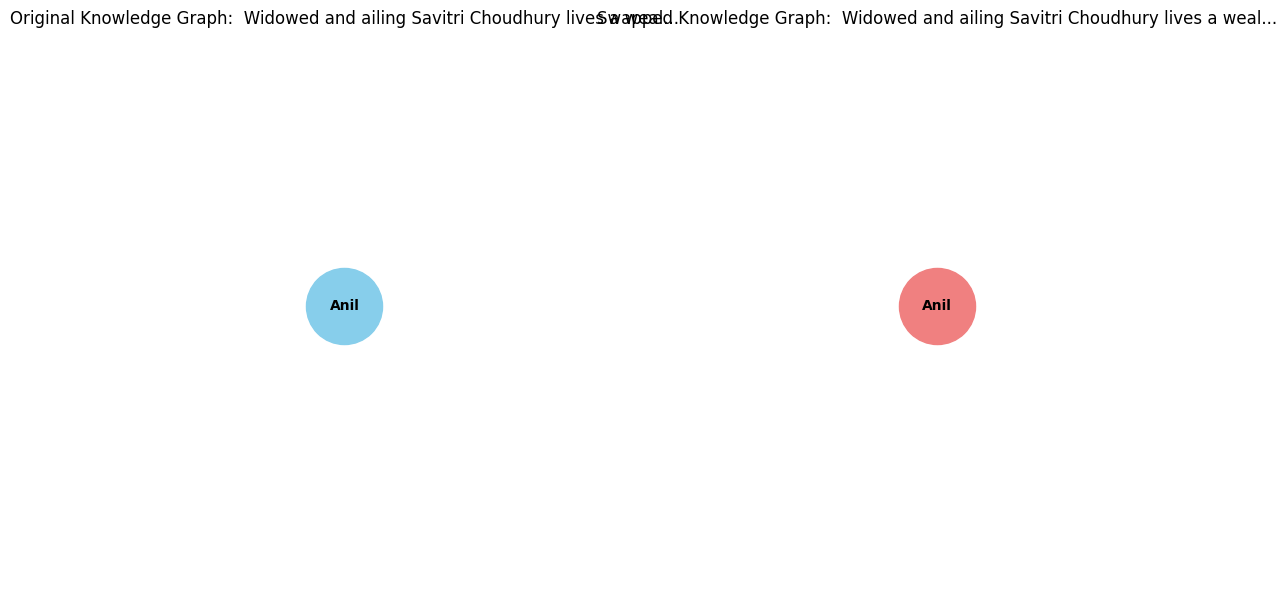

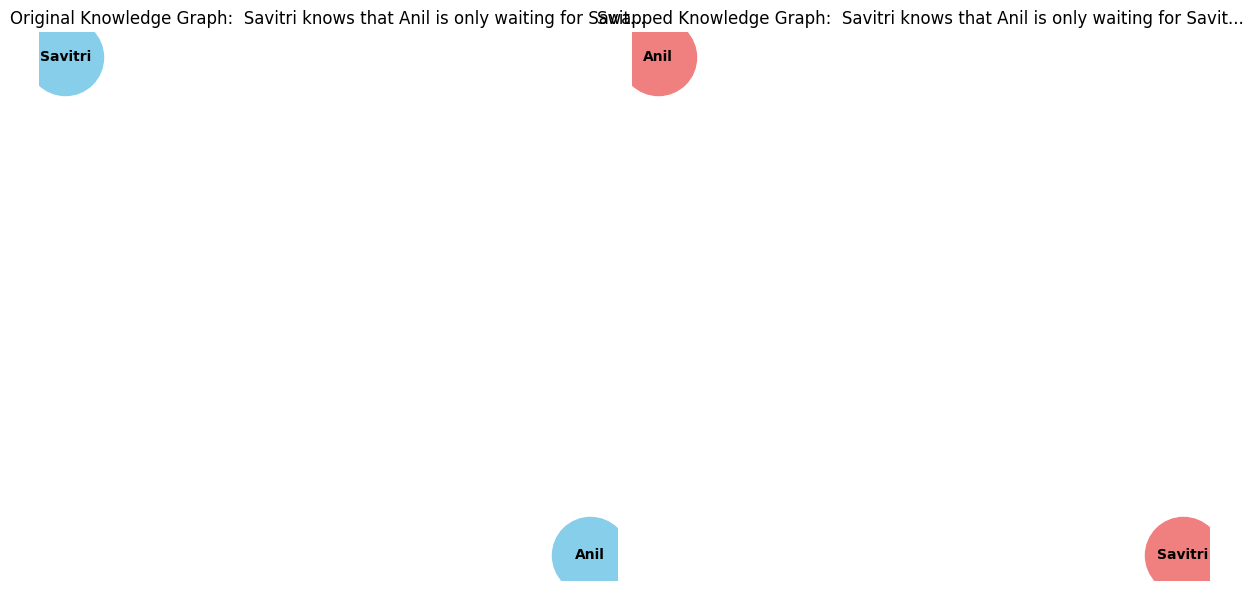

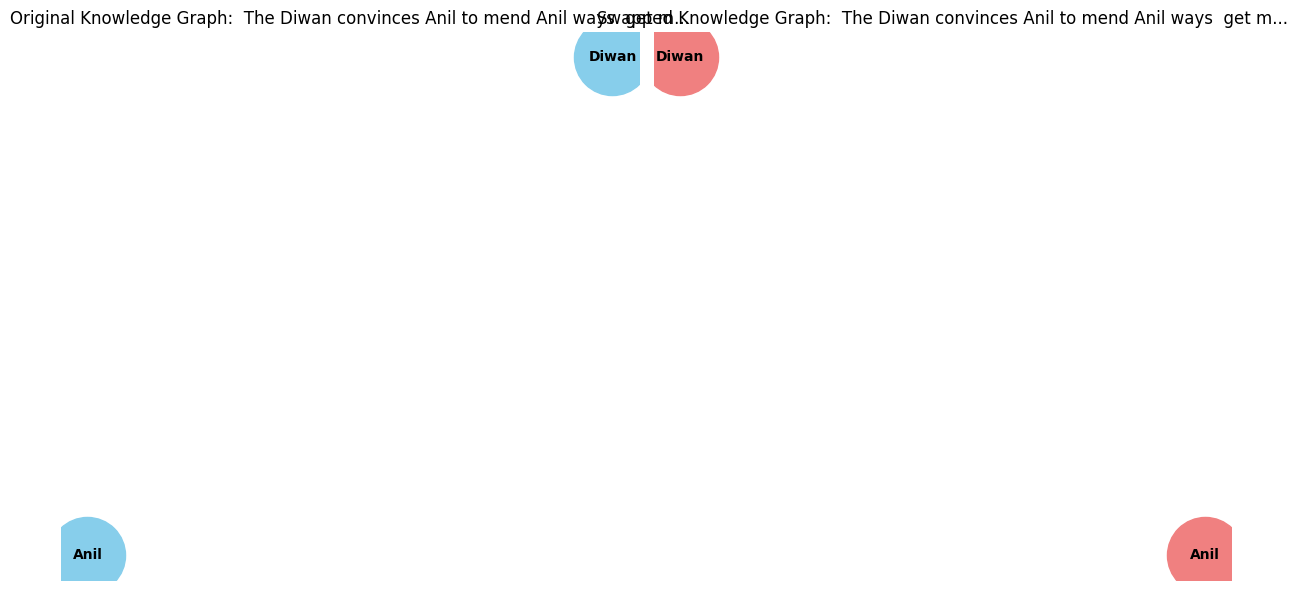

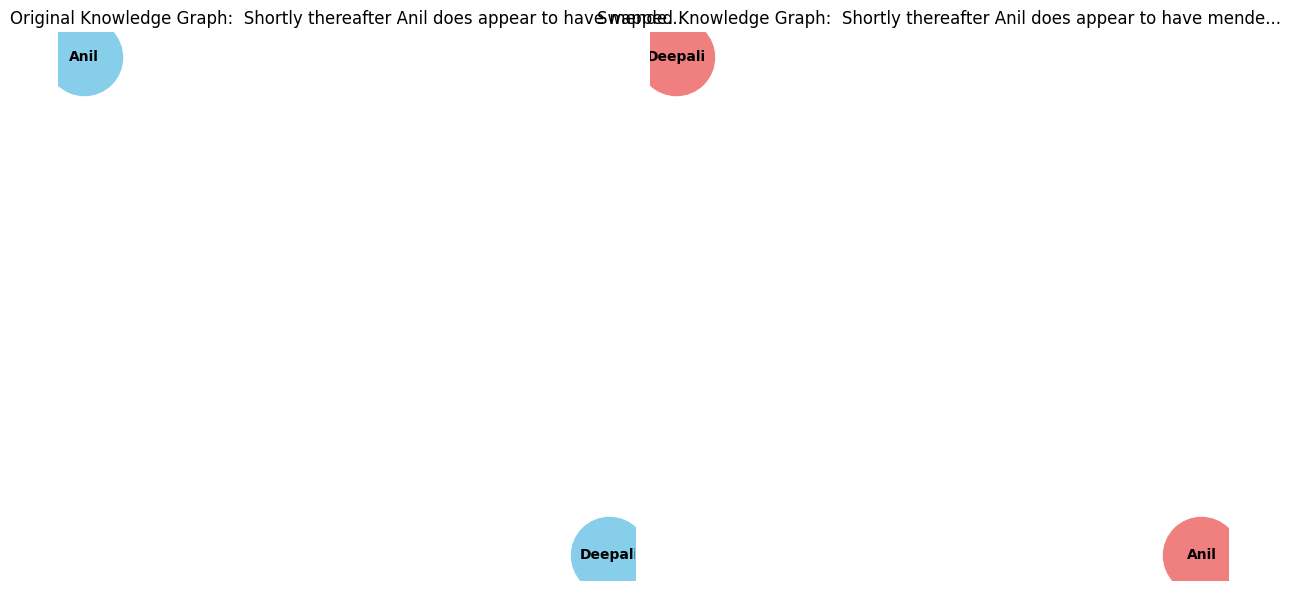

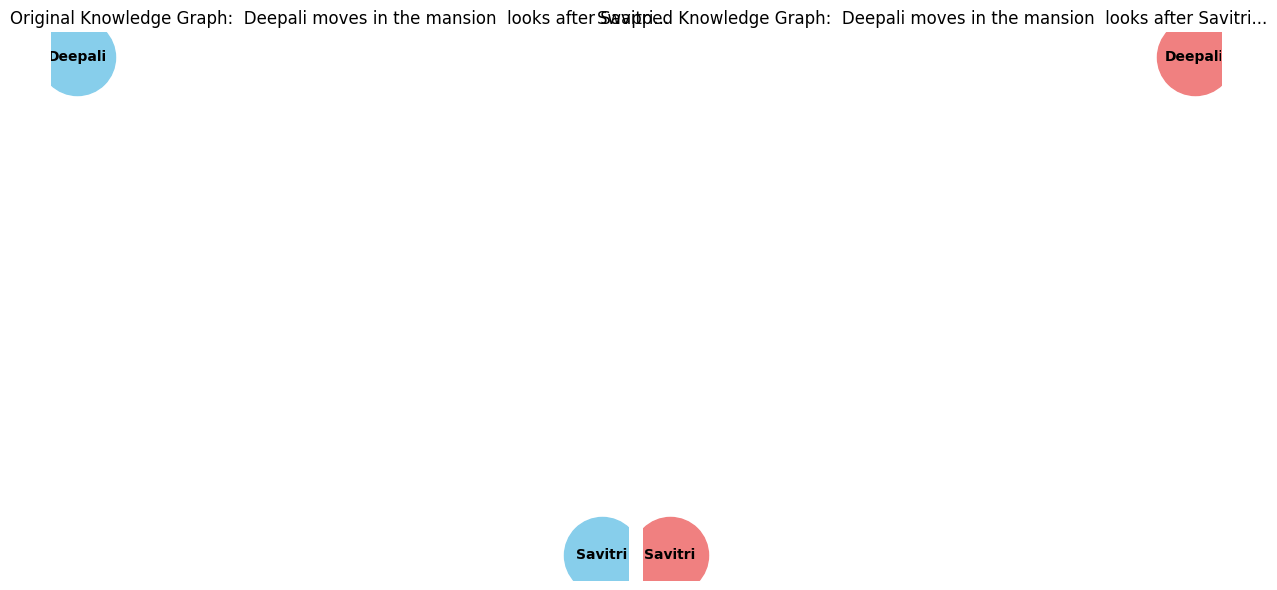

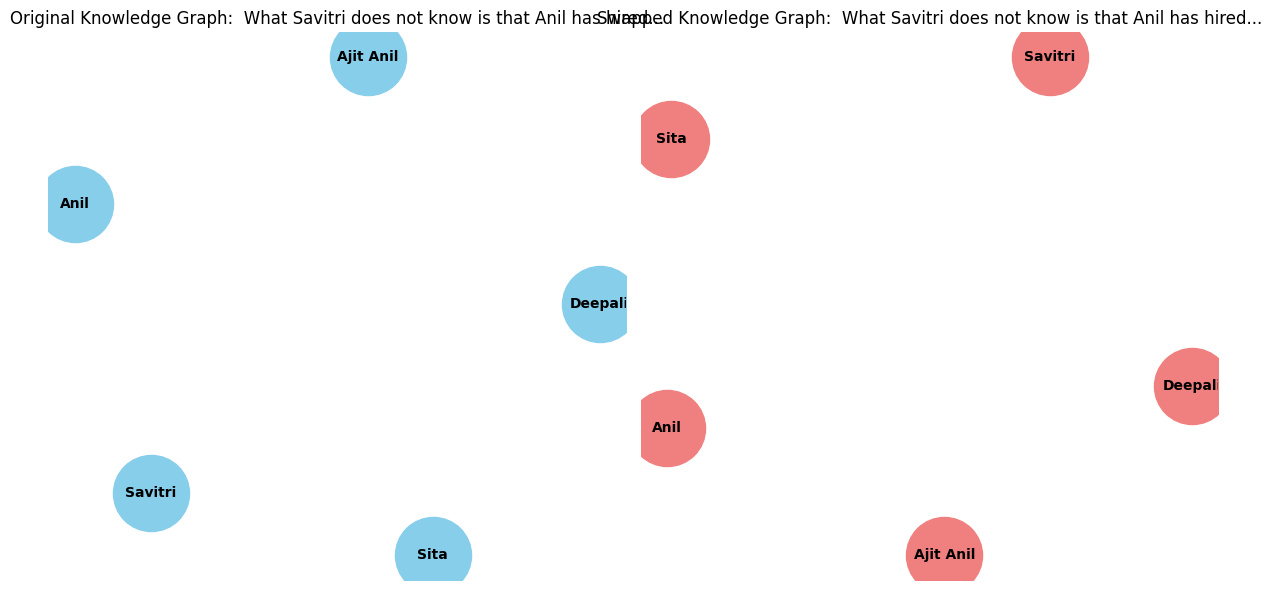

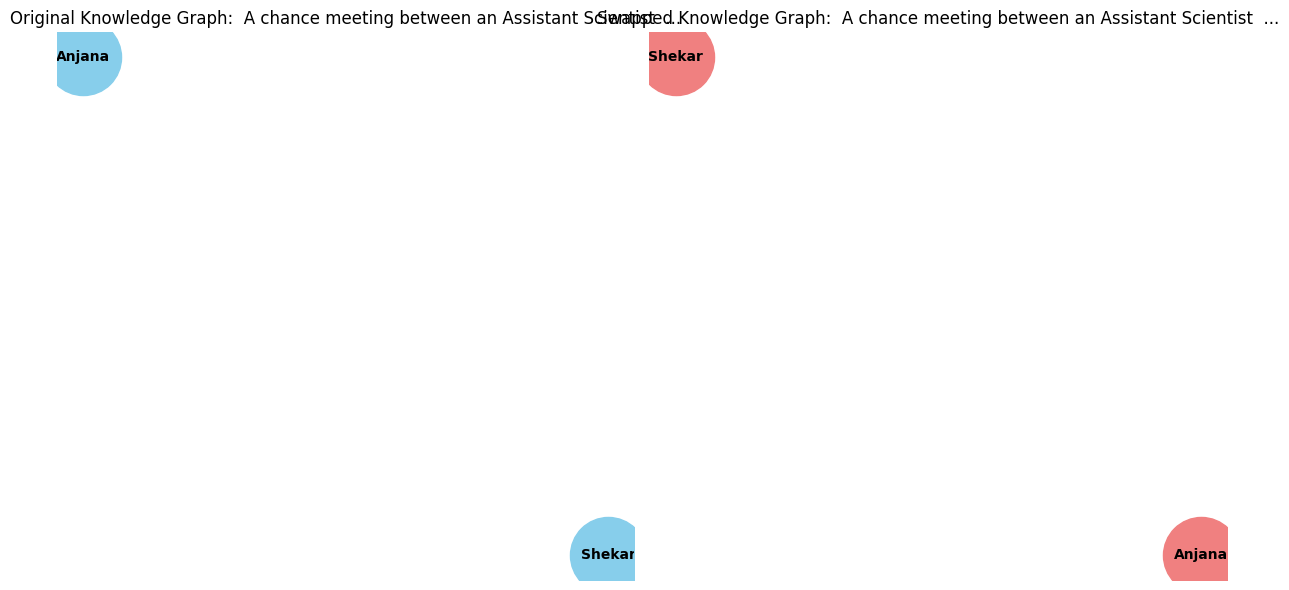

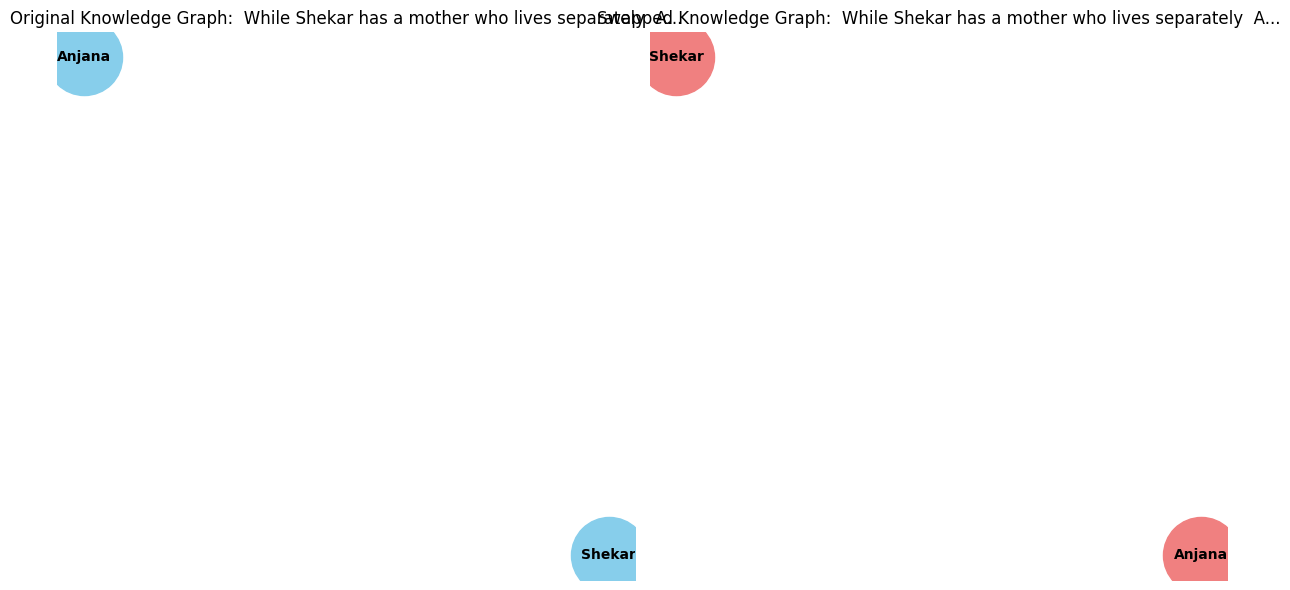

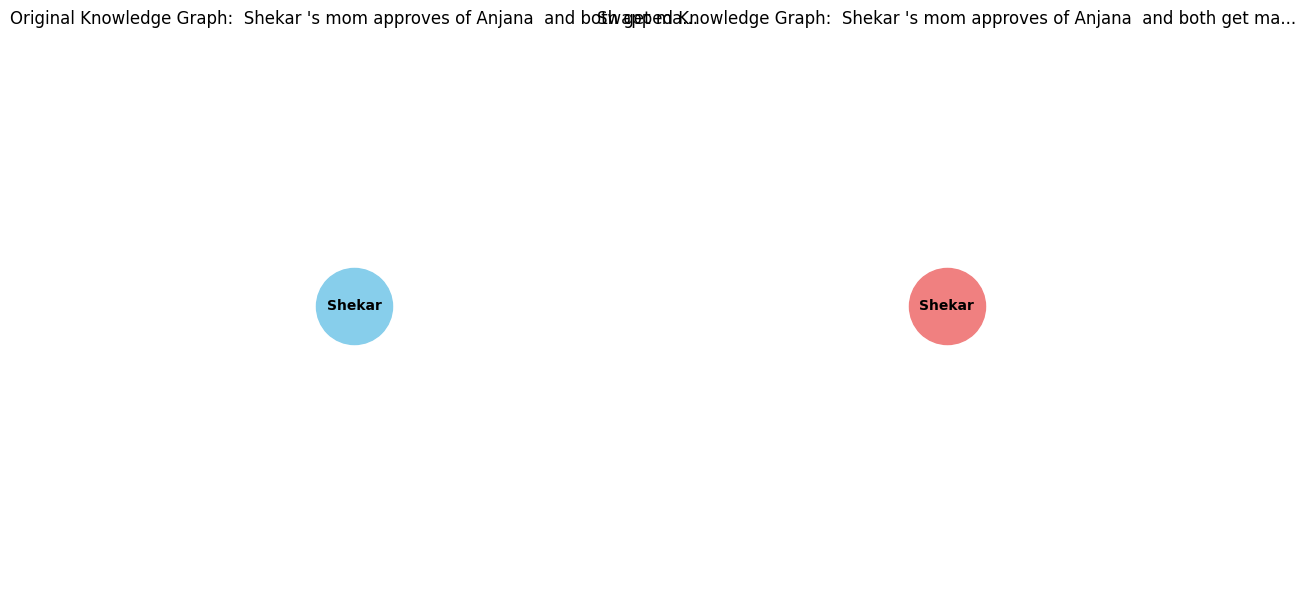

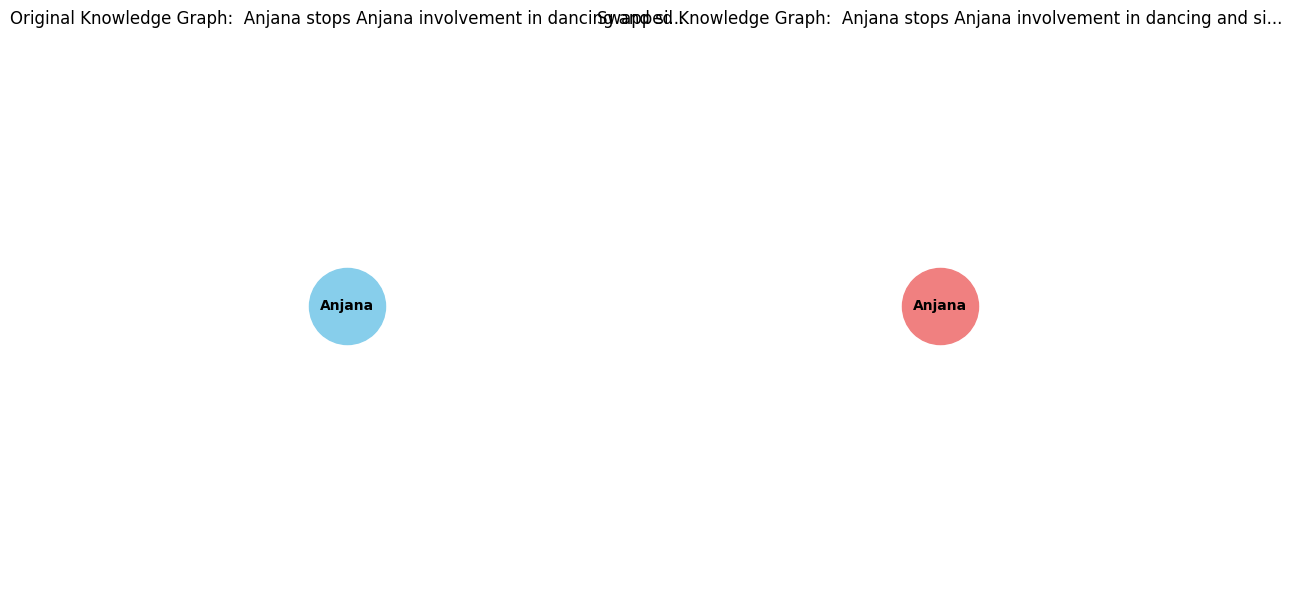

                                     Original Script  \
0   Widowed and ailing Savitri Choudhury lives a ...   
1   Savitri knows that Anil is only waiting for S...   
2   The Diwan convinces Anil to mend Anil ways  g...   
3   Shortly thereafter Anil does appear to have m...   
4   Deepali moves in the mansion  looks after Sav...   
5   What Savitri does not know is that Anil has h...   
6   A chance meeting between an Assistant Scienti...   
7   While Shekar has a mother who lives separatel...   
8   Shekar 's mom approves of Anjana  and both ge...   
9   Anjana stops Anjana involvement in dancing an...   

                         Original Characters Original Relationships  \
0                                     {Anil}                     []   
1                            {Savitri, Anil}                     []   
2                              {Diwan, Anil}                     []   
3                            {Deepali, Anil}                     []   
4                         {D

In [30]:
import spacy
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from genderize import Genderize

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize the Genderize API
genderize = Genderize()

# Function to extract entities (characters) and relationships from a script
def extract_entities_and_relations(script):
    """
    Extracts entities (characters) and their relationships from a script.
    This is a simplified function that uses SpaCy to detect named entities and relationships.
    """
    doc = nlp(script)
    characters = set()
    relationships = []

    for ent in doc.ents:
        if ent.label_ in ["PERSON"]:
            characters.add(ent.text)
    
    # Create dummy relationships based on subject-object pairs for demonstration
    for i in range(len(doc) - 1):
        if doc[i].dep_ == "nsubj" and doc[i + 1].dep_ == "dobj":
            relationships.append((doc[i].text, "talks to", doc[i + 1].text))
    
    return characters, relationships

# Function to swap genders in a script (replace names and pronouns)
def gender_swap(script, characters):
    """
    Swaps genders in a script based on detected gender.
    """
    swapped_script = script
    gender_dict = {}

    # Detect gender for each character (dummy approach, can be enhanced)
    for char in characters:
        gender = genderize.get([char])  # Pass the name as a list
        if gender:
            gender_dict[char] = gender[0]["gender"]

    # Simple gender swapping (replace "he" with "she", etc.)
    swapped_script = swapped_script.replace("he", "she").replace("she", "he")  # Simple swap
    
    # Further logic could swap names or pronouns (e.g., John to Jane)
    
    return swapped_script

# Function to build the knowledge graph
def build_knowledge_graph(characters, relationships):
    """
    Builds a knowledge graph using characters and their relationships.
    """
    G = nx.Graph()
    
    # Add nodes for each character
    for char in characters:
        G.add_node(char)
    
    # Add edges for each relationship
    for rel in relationships:
        G.add_edge(rel[0], rel[2], relation=rel[1])
    
    return G

# Load the dataset (adjust the path to your dataset)
df = pd.read_csv("wikipedia-data/coref_plot.csv")  # Adjust the path to your dataset

# Extract the first 10 plots from the dataset (adjust as needed)
df = df.head(10)
plots = df['Coref Plot']

# Initialize a list to store the analysis results
results = []

# Iterate through each plot, extract entities, generate swapped script, and build knowledge graphs
for plot in plots:
    # Extract characters and relationships for the original plot
    characters, relationships = extract_entities_and_relations(plot)
    
    # Swap genders in the script
    swapped_script = gender_swap(plot, characters)
    
    # Extract characters and relationships from the swapped script
    swapped_characters, swapped_relationships = extract_entities_and_relations(swapped_script)
    
    # Build knowledge graphs
    original_G = build_knowledge_graph(characters, relationships)
    swapped_G = build_knowledge_graph(swapped_characters, swapped_relationships)
    
    # Visualize original and swapped knowledge graphs
    plt.figure(figsize=(12, 6))
    
    # Original graph
    plt.subplot(1, 2, 1)
    nx.draw(original_G, with_labels=True, font_weight='bold', node_color='skyblue', node_size=3000, font_size=10)
    plt.title(f"Original Knowledge Graph: {plot[:50]}...")  # Show first 50 chars of plot for title
    
    # Swapped graph
    plt.subplot(1, 2, 2)
    nx.draw(swapped_G, with_labels=True, font_weight='bold', node_color='lightcoral', node_size=3000, font_size=10)
    plt.title(f"Swapped Knowledge Graph: {plot[:50]}...")  # Show first 50 chars of plot for title
    
    plt.tight_layout()
    plt.show()
    
    # Store results
    results.append({
        "Original Script": plot,
        "Original Characters": characters,
        "Original Relationships": relationships,
        "Original Knowledge Graph": original_G,
        "Swapped Script": swapped_script,
        "Swapped Characters": swapped_characters,
        "Swapped Relationships": swapped_relationships,
        "Swapped Knowledge Graph": swapped_G
    })

# Create DataFrame to store the results
df_analysis = pd.DataFrame(results)

# Display the results
print(df_analysis)

# Save the results to a new CSV file
df_analysis.to_csv("analyzed_plots_with_original_and_swapped_graphs.csv", index=False)


# Gender Stereotype Detection and Elimination in Movie Plots

## Introduction

Gender stereotypes in media are a long-standing issue, influencing how characters are portrayed based on traditional gender norms. In this project, we aim to detect and eliminate gender stereotypes in movie plots by swapping gendered pronouns and roles. The goal is to explore how a movie plot would look if the genders of the main characters were swapped, thereby challenging the stereotypical roles often associated with specific genders.

## Algorithm Overview

We use a **Transformer-based model** (BERT) to detect gendered language and pronouns in movie plot summaries. The key steps in the process are:

1. **Data Input**: A dataset of movie plots is provided, where each plot is a short description of a movie.
2. **Gender Detection**: The model classifies gendered pronouns and references (such as "he", "she", "his", "her", and character names) based on context using a pre-trained transformer model (`bert-base-uncased`).
3. **Gender Swap**: Once the gendered references are detected, the algorithm swaps male references (e.g., "he", "his", "John") with their female counterparts (e.g., "she", "her", "Jane"), and vice versa.
4. **Result**: The plot is transformed, and the modified plot (with swapped gender references) is stored for further review.

### Example of a Gender Swap:

For instance, if the plot contains the sentence:
> "John embarks on an adventure to save the world."

After applying the gender swap, the result will be:
> "Jane embarks on an adventure to save the world."

This simple replacement of gendered pronouns and names challenges the stereotypical narrative and prompts a reevaluation of the character's role in the plot.

## Challenges Encountered

While the model shows potential, there were certain limitations and challenges during the process:

1. **Time Constraints**: Due to time restrictions, I was unable to fully train or fine-tune the model on a large labeled dataset. As a result, the model's accuracy in detecting and eliminating gender stereotypes could be improved with more training data.
   
2. **Model Limitations**: The current model is not explicitly trained for gender stereotype detection in movie plots, so the swaps made are basic, focusing primarily on pronouns and names. More sophisticated analysis of the plot's narrative (e.g., character roles and behaviors) could lead to deeper stereotype elimination.

3. **Contextual Challenges**: Some gendered references are not straightforward, such as names (e.g., "Chris" or "Pat") that can be either male or female. The model is currently limited in addressing such cases without additional context.

## Next Steps for Improvement

To further improve the accuracy and effectiveness of this algorithm, the following steps can be taken:

1. **Fine-Tune the Model**: Train the model on a larger, labeled dataset containing gendered movie plots. This would allow the model to better understand the nuances of gendered language and roles within specific plot contexts.
   
2. **Gender-Neutral Terms**: Implement a more sophisticated gender swap by introducing gender-neutral terms, particularly in cases where the plot involves gender-neutral roles or characters. This would ensure that the swap is more inclusive.

3. **Contextual Role Adjustment**: Instead of just swapping pronouns and names, we could focus on analyzing the roles of characters in the plot. For example, if a character typically portrayed as a "hero" (often male) is swapped with a character of a different gender, their behavior and narrative arc might also need adjustments. A deeper analysis could be performed using **Named Entity Recognition (NER)** and **Coreference Resolution** to fully understand the character relationships and roles.

4. **Multi-Class Classification**: The model could be expanded to predict not just binary male/female genders but also handle non-binary or other gender identities, making the algorithm more inclusive and reflective of modern gender identities.

5. **Crowdsourcing Feedback**: Implement a feedback mechanism where users can provide input on whether they believe a gendered stereotype has been appropriately eliminated or swapped. This could be used to further refine the model.

## Conclusion

In this project, I attempted to create an algorithm for detecting and eliminating gender stereotypes in movie plots. While the model shows promise in detecting gendered references and performing basic swaps, there is still significant room for improvement. Further training, more data, and a deeper analysis of character roles could make this algorithm more effective at challenging gender stereotypes in media narratives.

Despite the time constraints, this approach serves as a foundational step towards exploring gender representation in media and offers a path for future research and development.